In [102]:
import numpy as np

# Grid parameters
N_x = 100
T = 1
d_x = 0.01
d_t = 0.001
time_steps = int(T // d_t)

# Boundary conditions
left_boundary = 0.7
right_boundary = 0.3

# Initialize arrays
h = np.zeros((time_steps, N_x + 2))
u = np.ones((time_steps, N_x + 2)) * -1

# Initial conditions
# h[0, :] = np.ones(N_x + 2) *
h[:, 0] = np.ones(time_steps ) * left_boundary
h[:, -1] = np.ones(time_steps ) * right_boundary
# h[:, 0] = np.linspace(left_boundary, 0, time_steps)
# h[:, -1] = np.linspace(right_boundary, 0, time_steps)
# h[:, 0] = abs(left_boundary * np.cos(2 * np.pi * np.linspace(0, 1, time_steps)))
# h[:, -1] = abs(right_boundary * np.sin(2 * np.pi * np.linspace(0, 1, time_steps)))

h[0, 1:N_x//2] = 0.7
# h[0, N_x//4:N_x//2] = 0.2
# h[0, N_x//2:3*N_x//4] = 0.3
h[0, N_x//2:-1] = 0.3

In [81]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def plot_u(i):
    plt.plot(u[i])
    plt.show()


def plot_u_all():
    ''' Plot u as a grid with x on the x-axis and t on the y-axis, and the values of x as the color '''
    plt.imshow(u, cmap='viridis', aspect='auto', origin='lower')
    plt.colorbar()
    plt.show()

def plot_h(i):
    plt.plot(h[i])
    plt.show()


def plot_h_all():
    ''' Plot h as a grid with x on the x-axis and t on the y-axis, and the values of h as the color.
        Time increases upward, with t=0 at the bottom. '''
    plt.imshow(h, cmap='viridis', aspect='auto', origin='lower')
    plt.colorbar(label='Water height h')
    plt.xlabel('Cell index')
    plt.ylabel('Time step') 
    plt.show()


def animate_h(fps=30, skip_frames=10, filename='h_animation.gif'):
    ''' Create an animation showing h(x) evolving through time.
        
        Args:
            fps: Frames per second for the animation
            skip_frames: Only plot every nth frame to speed up rendering (default: 10)
            filename: Name of the output GIF file (default: 'h_animation.gif')
    '''
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Set up the spatial grid
    x = np.linspace(0, N_x * d_x, N_x + 2)
    
    # Find global min/max for consistent y-axis
    h_min, h_max = h.min(), h.max()
    y_margin = (h_max - h_min) * 0.1
    
    # Initialize the line
    line, = ax.plot([], [], 'b-', linewidth=2)
    time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)
    
    ax.set_xlim(0, N_x * d_x)
    ax.set_ylim(h_min - y_margin, h_max + y_margin)
    ax.set_xlabel('Position x')
    ax.set_ylabel('Water height h')
    ax.set_title('Water Height Evolution')
    ax.grid(True, alpha=0.3)
    
    def init():
        line.set_data([], [])
        time_text.set_text('')
        return line, time_text
    
    def update(frame):
        i = frame * skip_frames
        if i >= time_steps:
            i = time_steps - 1
        line.set_data(x, h[i])
        time_text.set_text(f'Time: {i * d_t:.3f} s (step {i}/{time_steps})')
        return line, time_text
    
    n_frames = min(time_steps // skip_frames, time_steps)
    anim = FuncAnimation(fig, update, frames=n_frames, init_func=init, 
                         blit=True, interval=1000/fps)
    
    # Save the animation as a GIF
    anim.save(filename, writer='pillow', fps=fps)
    print(f'Animation saved as {filename}')
    
    plt.close()
    
    return HTML(anim.to_jshtml())


In [104]:
import numpy as np

def flux(u):
    return u * (1 - u)

h_crit = 0.5
def godunov_flux(uL, uR):
    if uL < uR:
        return min(flux(uL), flux(uR))
    elif uR > h_crit and uL > h_crit:
        return flux(uR)
    elif uL < h_crit and uR < h_crit:
        return flux(uL)
    else:
        return flux(h_crit)

def update_h(h):
    h_new = h.copy()
    for i in range(1, len(h)-1):
        F_right = godunov_flux(h[i], h[i+1])
        F_left  = godunov_flux(h[i-1], h[i])
        h_new[i] = h[i] - (d_t/d_x) * (F_right - F_left)
    h_new[0] = h_new[1]
    h_new[-1] = h_new[-2]
    return h_new

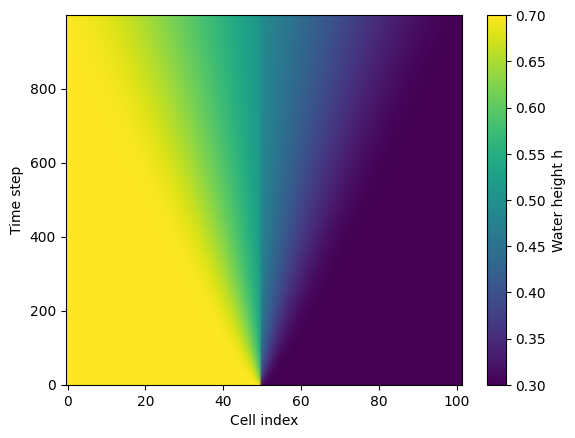

In [105]:
def solve_h():
    for i in range(1, time_steps):
        h[i] = update_h(h[i-1])

solve_h()

plot_h_all()


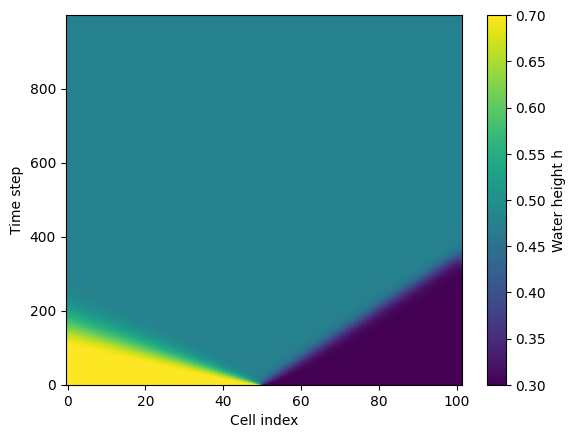

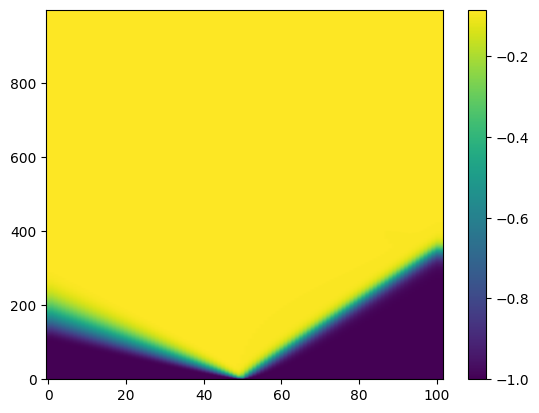

In [106]:
g = 9.81

def flux(h, u):
    """Physical flux F(U) for Saint-Venant in (h,u) form."""
    return np.array([h*u, h*u*u + 0.5*g*h*h])

def rusanov_flux(hL, uL, hR, uR):
    """Rusanov (LLF) flux computed from left/right (h,u)."""
    UL = np.array([hL, hL*uL])
    UR = np.array([hR, hR*uR])
    FL = flux(hL, uL)
    FR = flux(hR, uR)
    smax = max(abs(uL) + np.sqrt(g*hL), abs(uR) + np.sqrt(g*hR))
    return 0.5*(FL + FR) - 0.5*smax*(UR - UL)

def update_h_u(i):
    # compute fluxes at interfaces
    Fh = np.zeros(N_x+1)
    Fq = np.zeros(N_x+1)
    for n in range(N_x+1):
        F = rusanov_flux(h[i-1, n], u[i-1, n], h[i-1, n+1], u[i-1, n+1])
        Fh[n], Fq[n] = F[0], F[1]

    for n in range(1, N_x+1):
        # --- continuity ---
        h[i, n] = h[i-1, n] - (d_t / d_x) * (Fh[n] - Fh[n-1])

        # --- momentum ---
        q_old = h[i-1, n] * u[i-1, n]
        q_new = q_old - (d_t / d_x) * (Fq[n] - Fq[n-1])

        # --- recover velocity ---
        u[i, n] = q_new / (h[i, n] + 1e-6)  # note: divide by UPDATED h
    h[i, 0] = h[i, 1]
    h[i, -1] = h[i, -2]
    u[i, 0] = u[i, 1]
    u[i, -1] = u[i, -2]


def solve_h_u():
    for i in range(1, time_steps):
        update_h_u(i)

solve_h_u()
plot_h_all()
plot_u_all()

In [107]:
animate_h()

Animation saved as h_animation.gif
